In [0]:
! pip install networkx
! pip install plotly
! pip install colorlover

In [0]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import Counter
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import random
import colorlover as cl
from IPython.display import HTML
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import re

nltk.download("vader_lexicon") 
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



# Q2. Build a mention graph

In [0]:
df = pd.read_csv("tweets2009-06-0115.csv.zip", sep='\t', compression='zip')

In [0]:
allTweets = df["tweet"].str.cat(sep=' ')
tweetWords = [word.strip(""" ,.:'\";""").lower() for word in allTweets.split()]
hashTags = [word for word in tweetWords if word.startswith("#")]

In [0]:
# filter dataframe based on hashtag
quoteTag = df[df["tweet"].str.lower().str.contains("#quote", na=False)].copy()

In [0]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [0]:
quoteTag.head()

,date,user,tweet
265,2009-06-11 16:56:44,rboa_pr,RT @YouQuotedQuotes: Courage is resistance to ...
1637,2009-06-11 16:59:35,thewebchild,A man is a success if he gets up in the mornin...
3265,2009-06-11 17:03:07,ideadotcom,"RT @milliemiller: ""Logic will get you from A t..."
6054,2009-06-11 17:08:27,imhoturenot,#quote of the day: Always make sure to have ug...
9149,2009-06-11 17:11:38,allaboutenergy,"For my part I know nothing with any certainty,..."


In [0]:
addMentionedColumn(quoteTag)

In [0]:
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, numberMentions=1)
    
    return g

In [0]:
quoteGraph = mentionGraph(quoteTag)

## Q2(a)

In [0]:
print("# nodes:", len(quoteGraph.nodes()))
print("# edges:", len(quoteGraph.edges()))

# nodes: 2530
# edges: 3093


## Q2(b)

In [0]:
df_degree=pd.DataFrame(nx.degree(quoteGraph),columns=['node','degree'])
df_degree.head()

,node,degree
0,rboa_pr,1
1,youquotedquotes,20
2,ideadotcom,1
3,milliemiller,1
4,jslevin,1


Text(0, 0.5, 'frequency')

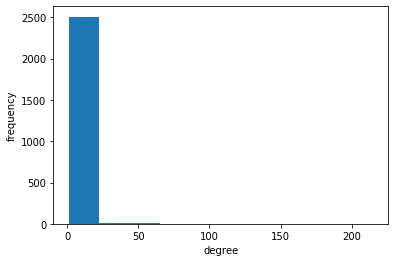

In [0]:
plt.hist(df_degree.degree.values)
plt.xlabel('degree')
plt.ylabel('frequency')

## Q2(c)

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [0]:
addRandomPositions(quoteGraph)

In [122]:
mention_data=[]

for user,mentioned_user,edges in quoteGraph.edges.data():
  mention_data.append([user,mentioned_user,edges['numberMentions']])

df_edge_weight=pd.DataFrame(mention_data,columns=['user','mentionUser','numberMentions'])
df_edge_weight=df_edge_weight.sort_values(by=['numberMentions'],ascending=False)
print('the edges of the top 5 highest weight are:')
df_edge_weight.head(5)

the edges of the top 5 highest weight are:


,user,mentionUser,numberMentions
1093,johngodzich,motivational,42
1091,johngodzich,tweetburst,23
430,mike_wesely,quotesource,22
211,lorimoreno,quotesource,19
880,ccopley,reapalife,16


## Q2(d)

In [0]:
# extract max and min numberMentions
maxMention=df_edge_weight['numberMentions'].max()
minMention=df_edge_weight['numberMentions'].min()

In [0]:
purd = cl.scales['9']['seq']['PuRd']
purd300 = cl.interp(purd, 300)

def plotNetworkSize(graph,maxMention,minMention):
    scatters=[]

    for (node1, node2, weights) in graph.edges.data():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        numberMention=weights['numberMentions']
        # edgeColor = int(299*(numberMention-minMention)/(maxMention-minMention))
        edgeColor = int(299*(numberMention)/(maxMention))
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,
                                  color=purd300[edgeColor]))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=5,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [131]:
configure_plotly_browser_state()
plotNetworkSize(quoteGraph,maxMention,minMention)

Output hidden; open in https://colab.research.google.com to view.

# Q3. Content analysis

## Q3(a)

In [0]:
def getTopK(tweet_array, k=20):
    stop = set(stopwords.words('english'))
    stop.add('quote')
    stop.add('quotes')
    stop.add('quotes')
    counter = Counter()
    for tweet in tweet_array:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', tweet) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [132]:
print('the most common words are')
print(getTopK(quoteTag.tweet.values))

the most common words are
[('http', 723), ('lorimoreno', 478), ('2009', 421), ('life', 344), ('mike_wesely', 328), ('love', 278), ('things', 252), ('screamingeagle1', 243), ('one', 237), ('make', 214), ('never', 210), ('bit', 196), ('like', 188), ('people', 174), ('com', 169), ('unknown', 139), ('man', 137), ('good', 135), ('get', 131), ('via', 130)]


In [0]:
tagger = PerceptronTagger()
pos_tag = tagger.tag

grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

chunker = nltk.RegexpParser(grammar)

In [0]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords_eng = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords_eng)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [0]:
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
def getTopKNP(tweet_array, k=20):
    stop = set(stopwords.words('english'))
    stop.add('quote')
    stop.add('quotes')
    stop.add('quotes')
    counter = Counter()
    for tweet in tweet_array:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', tweet)))) 
                            ]))
    topk = counter.most_common(k)  
    return topk

In [133]:
print('the most common NPs are:')
print(getTopKNP(quoteTag.tweet.values))

the most common NPs are:
[('rt mike_wes quot', 126), ('rt screamingeagle1', 106), ('rt lorimoreno', 84), ('rt sharonhay', 45), ('rt improvelif', 43), ('rt johna404 quot', 22), ('rt susancosmo', 20), ('winston churchil', 19), ('rt anewmod materi', 17), ('matter quot', 16), ('rt motiv', 16), ('lorimoreno quot', 16), ('http wefollow com twitter directori', 15), ('http bit', 15), ('golden rule', 15), ('anonym quot', 15), ('twitter tweet', 14), ('zig ziglar quot', 14), ('small thing', 13), ('rt anewmod', 13)]


## Answer for Q3(a)

The most common words can be matched to different meanings of the tag "quote":

* Terms like "screaming eagle 1", "LoriMoreno" are related with "prices" and "sponsorship". 

* Terms like "Winston Churchil" is probably mentioned when refers to famous historical people or events.

## Q3(b)

In [0]:
# random sampled to reduce the dataset in order to make plots visible
quoteTag_sampled=quoteTag.sample(frac=0.2,replace=False,random_state=1)
quoteGraph_sampled = mentionGraph(quoteTag_sampled)
addRandomPositions(quoteGraph_sampled)

In [0]:
def topWordDF(tagDF):
  topWord_data=[]
  for (index, date,user,tweet,mentioned) in tagDF.itertuples():
    user_tweet_array=tagDF[tagDF['user']==user]['tweet'].values
    top3word=getTopK(user_tweet_array, k=3)
    top3word_list=pd.DataFrame(top3word,columns=['word','count'])['word'].values
    topwords=','.join(top3word_list)
    topWord_data.append([user,topwords])

    # check if mentioned user has tweets
    for mentioned_user in mentioned:
      if mentioned_user not in tagDF['user'].values:
        topWord_data.append([mentioned_user,'NA'])
      else:
        mentioned_user_tweet_array=tagDF[tagDF['user']==mentioned_user]['tweet'].values
        mentioned_top3word=getTopK(mentioned_user_tweet_array, k=3)
        mentioned_top3word_list=pd.DataFrame(mentioned_top3word,columns=['word','count'])['word'].values
        mentioned_topwords=','.join(mentioned_top3word_list)
        topWord_data.append([mentioned_user,mentioned_topwords])
  return pd.DataFrame(topWord_data,columns=['user','topwords'])

In [145]:
nx.degree(quoteGraph)['rboa_pr']

1

In [0]:
df_usertopword=topWordDF(quoteTag)
df_usertopword_sampled=topWordDF(quoteTag_sampled)

In [0]:
def plotNetworkSize_commonword(graph,df):
    scatters=[]
    
    for (node1, node2, weights) in graph.edges.data():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        # numberMention=weights['numberMentions']
        # edgeColor = int(299*(numberMention-minMention)/(maxMention-minMention))
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,
                                  color="#888"))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text=node+'{topWord: '+df[df['user']==node]['topwords']+'} {degree: '+str(nx.degree(graph)[node])+'}',
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=5,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [156]:
# hover information: topword & degree of each node
configure_plotly_browser_state()
plotNetworkSize_commonword(quoteGraph,df_usertopword)

Output hidden; open in https://colab.research.google.com to view.

In [157]:
# common words plot for sampled data
configure_plotly_browser_state()
plotNetworkSize_commonword(quoteGraph_sampled,df_usertopword_sampled)

# Q4. Centrality analysis

## Q4(a)

In [0]:
# degree_centrality
degree_centrality_dict=nx.degree_centrality(quoteGraph)
degree_centrality_dict_sampled=nx.degree_centrality(quoteGraph_sampled)

In [0]:
degree_centrality_dict

{'rboa_pr': 0.00039541320680110717,
 'youquotedquotes': 0.007908264136022143,
 'ideadotcom': 0.00039541320680110717,
 'milliemiller': 0.00039541320680110717,
 'jslevin': 0.00039541320680110717,
 'dailycurmudgeon)': 0.00039541320680110717,
 'argentbeauquest': 0.0007908264136022143,
 'guykawasaki': 0.00039541320680110717,
 'dailycurmudgeon': 0.00276789244760775,
 'graftfinder': 0.0015816528272044287,
 'adevries': 0.0015816528272044287,
 'richstep51': 0.00039541320680110717,
 'wittykim': 0.00039541320680110717,
 'schwerdtfeger': 0.0015816528272044287,
 'firstpagepro': 0.0007908264136022143,
 'jawar': 0.004744958481613286,
 'j_belmont': 0.00039541320680110717,
 'improvelife': 0.02491103202846975,
 'mickyates': 0.0035587188612099647,
 'pixievixn37': 0.00039541320680110717,
 'ddunnaway': 0.00039541320680110717,
 'prosperbydesign': 0.00039541320680110717,
 'lightinggal': 0.0015816528272044287,
 'usermac': 0.00039541320680110717,
 'sharonhayes': 0.022933965994464216,
 'ihaps': 0.00039541320680

In [0]:
# betweenness_centrality
betweenness_centrality_dict=nx.betweenness_centrality(quoteGraph)
betweenness_centrality_dict_sampled=nx.betweenness_centrality(quoteGraph_sampled)

In [0]:
betweenness_centrality_dict

{'rboa_pr': 0.0,
 'youquotedquotes': 0.01139370606887612,
 'ideadotcom': 0.0,
 'milliemiller': 0.0,
 'jslevin': 0.0,
 'dailycurmudgeon)': 0.0,
 'argentbeauquest': 0.000635038615353044,
 'guykawasaki': 0.0,
 'dailycurmudgeon': 0.0044383881155807825,
 'graftfinder': 0.003849820993087685,
 'adevries': 0.0018925613453293548,
 'richstep51': 0.0,
 'wittykim': 0.0,
 'schwerdtfeger': 2.8154421370332e-06,
 'firstpagepro': 0.0004988862899596423,
 'jawar': 0.013199421872462602,
 'j_belmont': 0.0,
 'improvelife': 0.0509262982590826,
 'mickyates': 0.0037704675799743277,
 'pixievixn37': 0.0,
 'ddunnaway': 0.0,
 'prosperbydesign': 0.0,
 'lightinggal': 0.000683546745897519,
 'usermac': 0.0,
 'sharonhayes': 0.02987768229176667,
 'ihaps': 0.0,
 'terrencecohen': 0.0,
 'perfectpositive': 0.0,
 'lorimoreno': 0.13709209124989685,
 'letshearitforme': 0.0,
 'thewebchild': 0.04192406823412892,
 'wellofcreations': 0.0006451263196800341,
 'crazyjohnkerecz': 0.0,
 'timberwolf123': 3.343540276393965e-05,
 'twuoted

## Q4(b)

In [0]:
purd = cl.scales['9']['seq']['PuRd']
purd300 = cl.interp(purd, 300)

In [0]:
# reflect centrality using size & color

def plotNetworkSizeColor(graph,centrality_dict):
    maxCentr = max(centrality_dict.values())
    minCentr = min(centrality_dict.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = centrality_dict[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s\nCentrality: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=70*nodeCentr/maxCentr,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [0]:
# degree_centrality plot for complete data
configure_plotly_browser_state()
plotNetworkSizeColor(quoteGraph,degree_centrality_dict)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# degree_centrality plot for sampled data
configure_plotly_browser_state()
plotNetworkSizeColor(quoteGraph_sampled,degree_centrality_dict_sampled)

In [0]:
# betweenness_centrality plot for complete data
configure_plotly_browser_state()
plotNetworkSizeColor(quoteGraph,betweenness_centrality_dict)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# betweenness_centrality plot for sampled data
configure_plotly_browser_state()
plotNetworkSizeColor(quoteGraph_sampled,betweenness_centrality_dict_sampled)

## Q4(c)

## Answer for question Q4(c)

Key players: mike_wesely, lorimoreno, screamingeagle1, quotesource
* 1. The result are quite similar, centrality and betweenness plots have many common important user highlights. The reason is that, a high-degree user (named user A) connects to many other users, which would make other users necessairly go through user A to make new connections.

* 2. Betweenness, because a high betweenness node tends to be at the center of a network or the only connection between two communities. Therefore, reading the betweenness plot makes seek important users easier.

# Q5. Connectivity Patterns

## Q5(a)

In [85]:
# clique number of a graph: size of largest clique
print('clique number of a graph:',nx.graph_clique_number(quoteGraph))

clique number of a graph: 4


In [86]:
# number of maximal cliques 
# maximal clique: clique that cannot be extended by including one more adjacent vertex
max_cliques=[]
for max_clique in nx.find_cliques(quoteGraph):
  max_cliques.append(max_clique)
print('number of maximal clique:',len(max_cliques))

number of maximal clique: 2720


In [0]:
# number of maximal cliques for each node
node_num_of_clique_dict=nx.number_of_cliques(quoteGraph)

In [0]:
df_num_of_max_clique=pd.DataFrame(node_num_of_clique_dict,index=['num of clique'])
df_num_of_max_clique=df_num_of_max_clique.T
df_num_of_max_clique=df_num_of_max_clique.sort_values(by='num of clique',ascending=False)

In [87]:
print('The following dataframe summarizes the number of maximal cliques for each node (shown top 10 highest number)')
display(df_num_of_max_clique.head(10))

The following dataframe summarizes the number of maximal cliques for each node (shown top 10 highest number)


,num of clique
mike_wesely,201
lorimoreno,151
screamingeagle1,131
quotesource,85
anewmode,72
8elli,62
improvelife,56
sharonhayes,54
lindseyahawkins,48
thewebchild,46


## Q5(b)

In [0]:
cliques=[]
for clique in nx.enumerate_all_cliques(quoteGraph):
  cliques.append([clique,len(clique)])

In [120]:
df_cliques=pd.DataFrame(cliques,columns=['clique nodes','clique size'])
df_cliques=df_cliques.sort_values(by='clique size',ascending=False)
print('The maximal cliques have size 4 and they are:')
for value in df_cliques[df_cliques['clique size']==4]['clique nodes'].values:
  print(value)

The maximal cliques have size 4 and they are:
['market_renegade', 'dougpmd', 'joannaseetoo', 'lynlasneski']
['quotesource', 'screamingeagle1', 'thumbsupclub', 'catchourdream']
['mike_wesely', 'quotesource', 'thumbsupclub', 'catchourdream']
['thewebchild', 'quotesource', 'thumbsupclub', 'catchourdream']
['lorimoreno', 'mike_wesely', 'leadtoday', 'themodelcitizen']
['lorimoreno', 'mike_wesely', 'conniedr', 'ph1lm']
['lorimoreno', 'mike_wesely', 'drpatriciaross', 'themodelcitizen']
['lorimoreno', 'mike_wesely', 'quotesource', 'thumbsupclub']


## Answer for Q5(b)

* **Insights of relation between connectivity and answer in Q1**: A user in a clique should have mention relationships with all other users in the same clique. For example, the the nodes of the clique ['lorimoreno', 'mike_wesely', 'conniedr', 'ph1lm'] should be connected to each other in the mention graph.

* **Other clique properties**: The clique information also tells user communicity. Users in the sam clique should be in the same community or group. By investigating the clique, we can know how many communities are there and their members.
